In [2]:
# Load packages
import pandas as pd
import numpy as np
import time
import pytz
import matplotlib.pyplot as plt

import lxml.html as lx
import requests
import requests_cache

import newspaper
from newspaper import Article
from newspaper import news_pool

import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
import re

from sklearn.feature_extraction.text import CountVectorizer

import pickle

plt.rcParams["figure.figsize"] = [10, 8]

Useful links for newspaper3k:
https://opendatascience.com/using-the-newspaper-library-to-scrape-news-articles/
https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/

In [ ]:
# Test the newspaper function.
link = "https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html"
#link = 'https://krcrtv.com/news/butte-county/highway-70-to-be-closed-for-emergency-camp-fire-repairs'
#link = "http://krcrtv.com/news/butte-county/hundreds-of-trips-made-per-day-from-paradise-to-oroville-and-wheatland-with-debris"
#link = "https://krcrtv.com/news/camp-fire/camp-fire-debris-removal-could-be-halted-due-to-weather-cal-recycle-says"
article = Article(link)
article.download()
article.parse()
article.text

In [ ]:
# Get google news links for each search term
search_term_links = [
    "https://news.google.com/search?q=camp%20fire&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20death%20toll&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20california&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20paradise&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20map&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20news&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20cleanup&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20debris%20removal&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20pg&e&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20investigation&hl=en-US&gl=US&ceid=US%3Aen"
]

In [ ]:
# Get article links
def get_links(url):
    """Gets the article links for one Chronicle article list. The parameter "url" is the url to the 
    article list."""
    
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # Get the links that contain the word "article".
    #links = html.xpath("//div/a/@href")
    links = html.xpath("//*[contains(@class, 'NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')]/a/@href")

    return links

In [ ]:
# Get article links for each search term
l = [get_links(l) for l in search_term_links]

# Unlist the links and get the unique links.
links = [item for sublist in l for item in sublist]
links = np.unique(links)

len(links)

In [ ]:
# Extract text and publish data for the urls

def get_article_info(link):
    """Extract the title, text, publish date from a news article. The parameter link is the article link.
    Returns a dictionary of title, text, publish date, and url."""
    
    # Do not get the images.
    article = Article(link, fetch_images = False)
    
    # Not all articles can be downloaded/parsed.
    try:
        article.download()
        article.parse()
        
        title = article.title
        text = article.text # was in a try/except block
        date = article.publish_date
    except:
        # If article can't be parsed, set the variables to None.
        title = None
        text = None
        date = None
    
    url = link
    
    res = {"url": url, 
           "title": title, 
           "text": text,
           "date": date}
    
    return res

In [ ]:
# test it
link = links[1]
get_article_info(link)

In [ ]:
# Convert the article list to a dataframe.
articles = pd.DataFrame(article_list)

# Remove articles where we could not extract the the text.
articles = articles[~articles["text"].isna()]

# Convert the date column to datetime type
articles["date"] = pd.to_datetime(articles["date"], utc = True)

# Remove articles from paradise post (because this is from our local news source and we don't want overlap).
articles = articles[~articles["url"].str.contains("paradisepost")]

In [ ]:
# Extract article info. Returns a list of dictionaries.
# article_list = [get_article_info(x) for x in links]

# Save the dataframe
# articles.to_pickle("articles.txt")

# I saved the article dataframe with pickle so that I don't have to extract the article info again.
articles = pd.read_pickle("articles.txt")
articles.head()

In [7]:
# Only keep the title and text in this dataframe so we can merge all three news sources.
# articles_gn = articles.loc[:,['text', 'title']]
# articles_gn["title"] = articles_gn["title"].str.replace("\n","")
# articles_gn["source"] = "Google News"
# articles_gn

# Save the dataframe
#articles_gn.to_pickle("articles_gn.txt")
articles_gn = pd.read_pickle("articles_gn.txt")
articles_gn.head()

,text,title,source
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News


In [9]:
def tokenize_text(df):
    """Combine the strings in the "text" column of dataframe df into one long string. Then, tokenize the
    string and make all words lowercase."""
    
    # Combine the "text" column into a string.
    doc = ' '.join(df['text'].tolist())

    # Tokenize and make lowercase.
    words = nltk.word_tokenize(doc)
    words = [w.lower() for w in words]
    
    return words

In [10]:
# I took this function from Nick's lecture 2/14. It is for lemmitization.
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [11]:
def lemmatize_text(words):
    """Lemmatize words to get the base words. The input 'words' is a list of of words."""
    
    lemmatizer = nltk.WordNetLemmatizer()
    word_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]
    
    return words

In [12]:
def remove_stopwords(words):
    """Remove stopwords from a string."""
    
    stopwords = nltk.corpus.stopwords.words("english")
    words = [w for w in words if w not in stopwords]
    
    return words

In [ ]:
# Tokenize, lemmatize, and remove stopwords for the text of all articles.
words = tokenize_text(articles)
words = lemmatize_text(words)
words = remove_stopwords(words)
words = [w for w in words if w.isalnum()]

In [ ]:
# Create a frequency plot.
fq = nltk.FreqDist(w for w in words if w.isalnum())
fq.plot(25, title = "Top 25 Word Frequencies")

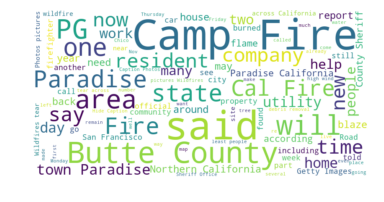

In [13]:
# Word cloud for all word articles we extracted from Google News.
doc = ' '.join(articles_gn['text'].tolist())
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
# This function is for cleaning the text for tfidf.
# I adapted this function from http://brandonrose.org/clustering so that it lemmitizes the words as well.

def tokenize_and_lem(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    lem = lemmatize_text(filtered_tokens)
    return lem


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate the tfidf matrix for all google articles combined.
text_list = articles_gn['text'].tolist()
vec = TfidfVectorizer(max_df = 0.8, min_df=0.2,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [ ]:
# Show tfidf dimensions.
tfidf

In [ ]:
# Show some of the terms in the tfidf.
terms = vec.get_feature_names()
terms[:10]

In [ ]:
# Tfidf for bigrams
text_list = articles['text'].tolist()
vec_bigram = TfidfVectorizer(min_df=0.1,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True,
                      ngram_range=(2,2))
tfidf_bigram = vec_bigram.fit_transform(text_list)

In [ ]:
# Show some of the terms from the bigram tfidf
terms_bigram = vec_bigram.get_feature_names()
terms_bigram[:10]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

In [ ]:
dist

In [ ]:
# Sample
articles.sample(5)

In [16]:
# Analysis of all articles and tweets
all_df = pd.read_pickle("all_df.txt")
all_df.head()

,text,title,source
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News


In [65]:
size = 30    # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
samp_all = all_u.groupby('source', as_index=False).apply(fn)
samp_all

text  \
0 507   Buy Photo The Northern California town of Para...   
  252   BUTTE COUNTY, Calif. - The Office of Emergency...   
  388   Contractors fired after poking fun at Camp Fir...   
  319   Hundreds of Northern California wildfire victi...   
  609   CONCOW, Butte County — When Scott realized tha...   
  655   \n\nOct. 3, 1933: Injured from the Griffith Pa...   
  225   1. Was 'Bird Box' filmed in Sacramento? Well, ...   
  485   As California's devastating wildfires burn thr...   
  106   Governor Newsom budgeting an EXTRA $305 millio...   
  606   PULGA, Butte County — A woman who lives near t...   
  579   Gov. Gavin Newsom should immediately allow the...   
  419   PULGA — Cal Fire investigators removed a cross...   
  127   The City of Maple Ridge is seeking a new injun...   
  620   DJI works with 16 first response agencies for ...   
  638   CLOSE Evacuation orders could be lifted in the...   
  318   To use this map from Cal Fire:\n\nCheck the bo...   
  236   BUTTE COUNTY, Calif. - Some Action News Now vi...   
  431   Looking for news you can trust?\n\nSubscribe t...   
  527   The 2017 wildfire season in California was amo...   
  85    - A Butte County man who saved more than 100 l...   
  264   This Feb. 18, 2019, photo provided by Ben Lepe...   
  102   SAN FRANCISCO (KGO) -- State regulators are no...   
  190   On Saturday, the Butte County Sheriff’s Office...   
  207   Nine buildings on the campus burned as well as...   
  537   California’s cleanup of the Camp Fire, the lar...   
  347   The first phase of the cleanup following Calif...   
  71    CHICO — The Chico City Council voted 4-3 on Tu...   
  467   PARADISE, Calif. — One huge fire was caused by...   
  384   Wildfires often become known by a name. How th...   
  250   Federal agencies are still looking for a place...   
...                                                   ...   
2 1800  La Pacific Gas &amp; Electric ammette che e' p...   
  301   At PayneMitchell, we have handled many cases a...   
  4292  The Camp Fire devastated the town of Paradise,...   
  870   PG&amp;E Says Its Equipment Probably Caused Ca...   
  272   Why ‘the Worst of Both Worlds’ Is in the Forec...   
  4469  More than 100 Camp Fire victims are being boot...   
  4380  California’s largest utility faces potential r...   
  292   The utility company said “it is probable that ...   
  3425  Explore a continent by train, camp out in a fi...   
  1648  RT @GeorgeHatcher: PG&amp;E records $10.5 bill...   
  486   RT @GStuedler: PG&amp;E Says For The First Tim...   
  2196  California wildfires are burning bigger and le...   
  1083  Pacific Gas and Electric says it "believes it ...   
  3203  California Gov. Gavin Newsom toured the area b...   
  3028  Dog reunited with family 101 days after Camp F...   
  51    @GRECOBroker @GavinNewsom @MSNBC California se...   
  481   PG&amp;E: Company equipment 'probable' cause o...   
  2606  This is Kingston, a very good boy who disappea...   
  3298  Months after a massive wildfire destroyed the ...   
  874   PG&amp;E Says Its Equipment Probably Caused Ca...   
  2157  RT @eldersclimate: California has just emerged...   
  705   PG&amp;E Says It Probably Caused the Fire That...   
  347   PG&amp;E says equipment probably caused Camp F...   
  173   NEW PODCAST: Fire &amp; Ice explores extreme w...   
  4417  YouTuber identifies 27 anomalies in the Califo...   
  2609  RT @JimPolk: Dog reunited 101 days after Calif...   
  1145  PG&amp;E admits its equipment ‘probably’ cause...   
  877   PG&amp;E Says Its Equipment Probably Caused Ca...   
  3188  RT @ariauber: Breweries are reaching the end o...   
  2067  A power line at the center of speculation over...   

                                                    title       source  
0 507   $3 billion or more: Heavy cost of cleanup for ...  Google News  
  252   Phase 1 of Camp Fire Debris Cleanup 86 Percent...  Google News  
  388   Contractors fired after poking fun at Camp 

In [71]:
# Generate the tfidf matrix for all google articles combined.
text_list = samp_all['text'].tolist()
vec = TfidfVectorizer(tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [72]:
tfidf

<90x4136 sparse matrix of type '<class 'numpy.float64'>'
	with 11084 stored elements in Compressed Sparse Row format>

In [73]:
terms = vec.get_feature_names()
terms[:10]

["'bird",
 "'if",
 "'ll",
 "'m",
 "'probable",
 "'re",
 "'s",
 "'ve",
 '-plus',
 '//t.co/221itbgmus']

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

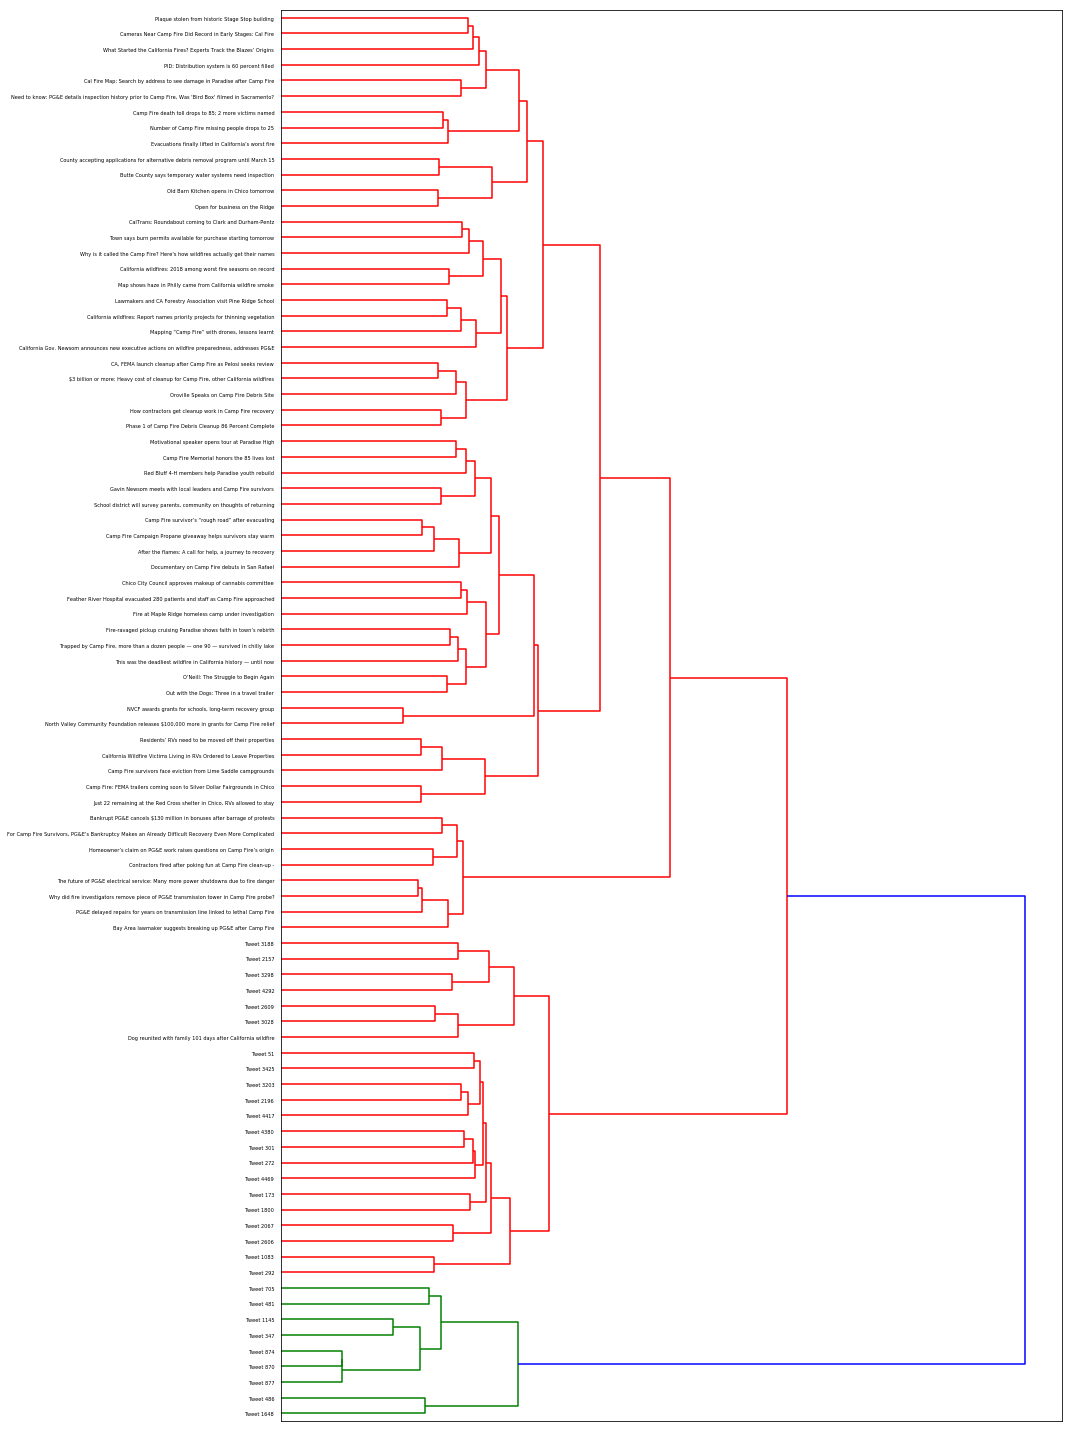

In [75]:
from scipy.cluster.hierarchy import ward, dendrogram


titles = samp_all["title"]

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

In [47]:
all_df["title"].nunique()

5486

In [48]:
all_df.shape

(5518, 3)

In [50]:
all_df["text"].nunique()

2566

In [76]:
all_u = all_df.drop_duplicates(subset=['text'])
all_u = all_u.drop_duplicates(subset=['title'])

all_u.to_pickle("all_nodup.txt")
#all_nodup = pd.read_pickle("all_nodup.txt")